In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from math import radians
from scipy.spatial.distance import cdist
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from k_means_constrained import KMeansConstrained
import numpy as np
from utils import haversine_distance, manhattan_distance
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose

In [ ]:
path = "ubicaciones.csv"

In [58]:
df = pd.read_csv(path)

In [59]:
scaler = MinMaxScaler()
fitted_scaler = scaler.fit(df[["lat", "lon"]])
scaled_coordinates = fitted_scaler.transform(df[["lat", "lon"]])

In [60]:
kmeans = KMeansConstrained(
     n_clusters=6,
     size_min=599,
     size_max=626,
     random_state=2020,
     n_init=100,
     max_iter=200,
     n_jobs = -1)
kmeans.fit(scaled_coordinates)
centroids = fitted_scaler.inverse_transform(kmeans.cluster_centers_)
df["kmeans"] = list(kmeans.predict(scaled_coordinates))

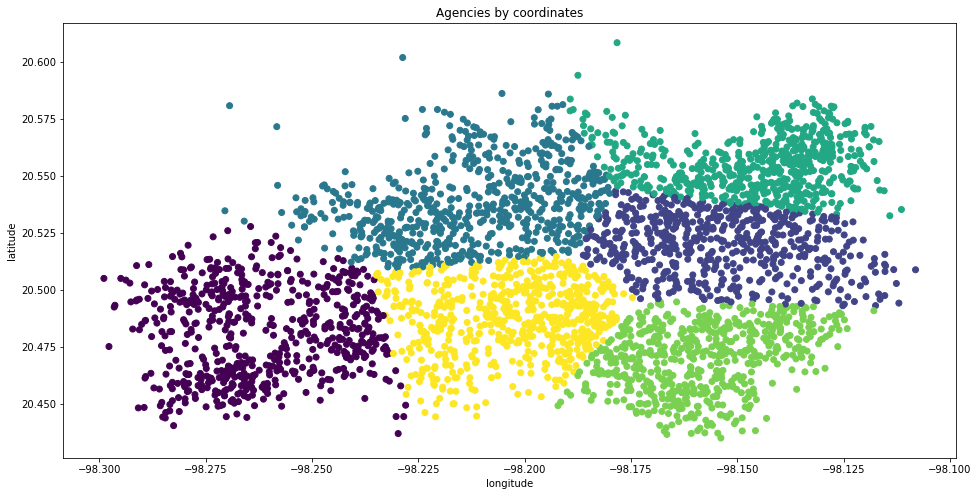

In [62]:
fig=plt.figure(figsize=(16, 8))
plt.scatter(df["lon"],df["lat"], c = df["kmeans"])
plt.title("Agencies by coordinates")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

In [63]:
pivoted_df = df.pivot(index = "Id_Cliente", columns = "kmeans", values = "Frecuencia")

In [64]:
frecuencia2 = df[df["Frecuencia"] == 2]
frecuencia2_index = frecuencia2.index
#kmeans_ranked2 = distance_matrix(scaled_coordinates[frecuencia2.index], kmeans.cluster_centers_)
kmeans_ranked2 = distance_matrix(scaled_coordinates[frecuencia2.index], kmeans.cluster_centers_)
frecuencia2_clusters = dict(zip(frecuencia2_index, np.argsort(kmeans_ranked2)[:, 1]))

In [65]:
frecuencia3 = df[df["Frecuencia"]==3]
frecuencia3_index = frecuencia3.index
#kmeans_ranked3 = distance_matrix(scaled_coordinates[frecuencia3.index], kmeans.cluster_centers_)
kmeans_ranked3 = distance_matrix(scaled_coordinates[frecuencia3.index],kmeans.cluster_centers_)
frecuencia3_clusters = dict(zip(frecuencia3_index, np.argsort(kmeans_ranked3)[:, [1, 2]]))

In [66]:
for index, cluster in frecuencia2_clusters.items():
    pivoted_df.iloc[index, cluster] = 1
for index, cluster in frecuencia3_clusters.items():
    pivoted_df.iloc[index, cluster[0]] = 1
    pivoted_df.iloc[index, cluster[1]] = 1

In [67]:
pivoted_df.replace(2, 1, inplace = True)
pivoted_df.replace(3, 1, inplace = True)
pivoted_df.fillna(0, inplace = True)
final_df = pivoted_df.astype(int).rename(columns={0: "D1", 1: "D2", 2: "D3", 3:"D4", 4:"D5", 5: "D6"})

In [68]:
final_df.to_csv("csv_files/kmeans_balanced_weighted_freq_vol_entrega.csv", header = True, index = True)

In [77]:
def test_balanced_stops(transformed_df, balance_base = "default"):
    """
    Calculates the deviation of the stops per cluster.
    Args:
        transformed_df : pandas dataframe pivoted
        balance_base : "default if using all the necessary stops in the given problem
    Returns:
        deviation: float
    """
    if balance_base == "default":
        base = 3977
    else:
        base = transformed_df.shape[0]
    balanced_stops = transformed_df.iloc[:, 1:].sum()
    print(balanced_stops)
    balance_per = balanced_stops / base
    deviation = ((balance_per - (1/6))**2).sum()/6
    return(deviation)

In [78]:
def test_balanced_distributions(transformed_df, main_df):
    """
    Calculates the deviation of delivery volumes.
    Args:
        transformed_df : pandas dataframe pivoted
        main_df : main_df used
    Returns:
        deviation: float
    """
    assert transformed_df.shape[0] == main_df.shape[0]
    joined_df = transformed_df.join(main_df[["Id_Cliente", "Vol_Entrega", "Frecuencia"]], on="Id_Cliente", how = "inner", rsuffix="_transformed")
    joined_df.drop("Id_Cliente_transformed" ,axis = 1, inplace = True)
    base = (joined_df.Frecuencia * joined_df.Vol_Entrega).sum()
    zones = ["D1", "D2", "D3", "D4", "D5", "D6"]
    zone_volumes = []
    for zone in zones:
        print(zone)
        print((joined_df[zone] * joined_df["Vol_Entrega"]).sum())
        zone_volumes.append((((joined_df[zone] * joined_df["Vol_Entrega"]).sum() / base) - (1/6))**2)
    deviation = sum(zone_volumes) / 6
    return(deviation)

In [71]:
def distance_intra_cluster(transformed_df, main_df, centroids):
    """
    Calculates the distance from the centroid to each point.
    Args:
        transformed_df : pandas dataframe pivoted
        main_df : main df used
    Returns:
        manhattan distance and harvesine distance
    """
    zones = ["D1", "D2", "D3", "D4", "D5", "D6"]
    centroids_map = dict(zip(zones, centroids))
    centroids_df = pd.DataFrame.from_dict(centroids_map, orient = "index", columns = ["lat_centroids", "lon_centroids"])
    centroids_df = centroids_df.reset_index().rename(columns = {"index":"zones"})
    
    unpivoted_df = pd.melt(transformed_df, id_vars=['Id_Cliente'], var_name= "zones")
    unpivoted_df = unpivoted_df[unpivoted_df.value>0]
    joined_df = unpivoted_df.merge(main_df[["Id_Cliente", "lat", "lon"]], on="Id_Cliente", how = "left")\
                            .merge(centroids_df,  on="zones", how = "left")
    joined_df["manhattan"] = manhattan_distance(joined_df["lat"], joined_df["lon"], joined_df["lat_centroids"], joined_df["lon_centroids"])
    joined_df["haversine"] = haversine_distance(joined_df["lat"], joined_df["lon"], joined_df["lat_centroids"], joined_df["lon_centroids"])
    print("Manhattan Distance")
    print(joined_df.groupby("zones")["manhattan"].sum())
    print("Haversine Distance")
    print(joined_df.groupby("zones")["haversine"].sum())
    return(joined_df["manhattan"].sum(), joined_df["haversine"].sum())

In [72]:
def tsp_zone_distance(transformed_df, main_df):
    """
    Calculates the deviation of the stops per cluster.
    Args:
        transformed_df : pandas dataframe pivoted
        main_df :  main df used
    Returns:
        deviation: float
    """
    zones = ["D1", "D2", "D3", "D4", "D5", "D6"]
    unpivoted_df = pd.melt(transformed_df, id_vars=['Id_Cliente'], var_name= "zones")
    unpivoted_df = unpivoted_df[unpivoted_df.value>0]
    joined_df = unpivoted_df.merge(main_df[["Id_Cliente", "lat", "lon"]], on="Id_Cliente", how = "left")
    total_distance = []
    for zone in zones:
        fitness_coords = mlrose.TravellingSales(coords = joined_df[joined_df["zones"]==zone][["lat", "lon"]].to_numpy())
        problem_fit = mlrose.TSPOpt(length = joined_df[joined_df["zones"]==zone].shape[0], fitness_fn = fitness_coords,
                            maximize=False)
        best_state, best_fitness = mlrose.genetic_alg(problem_fit, random_state = 12)
        total_distance.append(best_fitness)
    print(total_distance)
    return(sum(total_distance))

In [79]:
test_balanced_stops(final_df, balance_base = "default")

kmeans
D2    661
D3    664
D4    632
D5    657
D6    726
dtype: int64


5.2471186126680244e-05

In [80]:
test_balanced_distributions(final_df.reset_index(), df)

D1
9103.33333333
D2
8667.833333336
D3
8893.5
D4
7200.166666663
D5
9384.66666667
D6
10372.0


0.00030857601327619803

In [75]:
distance_intra_cluster(final_df.reset_index(), df, centroids)

Manhattan Distance
zones
D1    20.346709
D2    19.036551
D3    20.067400
D4    15.282845
D5    17.367076
D6    21.839896
Name: manhattan, dtype: float64
Haversine Distance
zones
D1    1711.397905
D2    1603.045694
D3    1710.341799
D4    1280.620538
D5    1465.232396
D6    1829.387519
Name: haversine, dtype: float64


(113.94047674785534, 9600.025851346902)

In [76]:
tsp_zone_distance(final_df.reset_index(), df)

[20.440431455815347, 19.813115964089175, 20.634819837369335, 15.836584421846545, 17.77564218615105, 22.77568208505854]


117.27627595032999